In [ ]:
import urllib.request
import zipfile
import os
from pathlib import Path

# Define file paths
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    """
    Downloads and extracts the SMS Spam Collection dataset if not already present.
    """
    # Check if the dataset already exists
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Download the zip file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Extract the zip file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Rename the extracted file to include the .tsv extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)

    print(f"File downloaded and saved as {data_file_path}")

# Execute the function
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [ ]:
import pandas as pd
df = pd.read_csv(
 data_file_path, sep="\t", header=None, names=["Label", "Text"]
)
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


# Dataset preparation

In [ ]:
print(df["Label"].value_counts())


Label
ham     4825
spam     747
Name: count, dtype: int64


In [ ]:
import pandas as pd

def create_balanced_dataset(df):
    """
    Creates a balanced dataset by undersampling the 'ham' messages to match the number of 'spam' messages.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing a "Label" column with 'spam' and 'ham' values.

    Returns:
        pd.DataFrame: A balanced DataFrame with an equal number of 'spam' and 'ham' messages.
    """
    # Count the number of spam messages
    num_spam = df[df["Label"] == "spam"].shape[0]

    # Randomly sample the same number of ham messages
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

    # Combine the sampled ham messages with all spam messages
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

# Create the balanced dataset
balanced_df = create_balanced_dataset(df)

# Display the counts of each label
print(balanced_df["Label"].value_counts())


Label
ham     747
spam    747
Name: count, dtype: int64


In [ ]:
print(balanced_df["Label"].unique())


['ham' 'spam']


In [ ]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})
print(balanced_df["Label"].unique())


[0 1]


In [ ]:
import pandas as pd

def random_split(df, train_frac, validation_frac):
    """
    Splits a DataFrame into training, validation, and test sets.

    Parameters:
        df (pd.DataFrame): The input DataFrame to be split.
        train_frac (float): The fraction of data to be used for training.
        validation_frac (float): The fraction of data to be used for validation.

    Returns:
        tuple: Three DataFrames - (train_df, validation_df, test_df)
    """
    # Shuffle the dataset randomly
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Compute split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the dataset
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

# Perform the split on the balanced dataset
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

# Print dataset sizes
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(validation_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 1045
Validation set size: 149
Test set size: 300


In [ ]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)


In [ ]:
!pip install tiktoken

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [ ]:
import torch
import pandas as pd
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    """
    Custom PyTorch Dataset for SMS Spam Classification.

    Parameters:
        csv_file (str): Path to the CSV file containing text and labels.
        tokenizer: Tokenizer used to encode the text.
        max_length (int, optional): Maximum length of encoded sequences. If None, uses the longest sequence in the dataset.
        pad_token_id (int): Token ID used for padding.

    Returns:
        torch.utils.data.Dataset: A PyTorch dataset with tokenized and padded text inputs.
    """

    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Tokenize all text samples
        self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]

        # Determine max sequence length
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length

        # Truncate longer sequences
        self.encoded_texts = [
            encoded_text[:self.max_length] for encoded_text in self.encoded_texts
        ]

        # Pad shorter sequences
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        """
        Returns a single data sample (tokenized text and label).
        """
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long),
        )

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.data)

    def _longest_encoded_length(self):
        """
        Finds the longest encoded sequence length in the dataset.
        """
        return max(len(encoded_text) for encoded_text in self.encoded_texts)


In [ ]:
train_dataset = SpamDataset(
 csv_file="train.csv",
 max_length=None,
 tokenizer=tokenizer
)

In [ ]:
# the number of tokens in the longest sequence
print(train_dataset.max_length)


120


In [ ]:
# pad the validation and test sets to match the length of the longest training sequence
val_dataset = SpamDataset(
 csv_file="validation.csv",
 max_length=train_dataset.max_length,
 tokenizer=tokenizer
)
test_dataset = SpamDataset(
 csv_file="test.csv",
 max_length=train_dataset.max_length,
 tokenizer=tokenizer
)

In [ ]:
from torch.utils.data import DataLoader
import torch

# Set random seed for reproducibility
torch.manual_seed(123)

# Define DataLoader parameters
num_workers = 0  # Number of subprocesses for data loading
batch_size = 8    # Number of samples per batch

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,      # Shuffle training data
    num_workers=num_workers,
    drop_last=True     # Drop last incomplete batch (if any)
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,     # No need to shuffle validation data
    num_workers=num_workers,
    drop_last=False    # Keep all batches
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,     # No need to shuffle test data
    num_workers=num_workers,
    drop_last=False    # Keep all batches
)


In [ ]:
for input_batch, target_batch in train_loader:
 pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [ ]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


# Model setup

In [ ]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

In [ ]:
BASE_CONFIG = {
 "vocab_size": 50257,
 "context_length": 1024,
 "drop_rate": 0.0,
 "qkv_bias": True
}
model_configs = {
 "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
 "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
 "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
 "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])


In [ ]:
import urllib.request
url = (
 "https://raw.githubusercontent.com/rasbt/"
 "LLMs-from-scratch/main/ch05/"
 "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7d660a295ad0>)

In [ ]:
import torch

def assign(left, right):
    """
    Assigns values from `right` to `left`, ensuring shape compatibility.

    Parameters:
        left (torch.Tensor): Target tensor.
        right (numpy.ndarray or torch.Tensor): Source tensor.

    Returns:
        torch.nn.Parameter: The assigned tensor wrapped as a trainable parameter.

    Raises:
        ValueError: If the shapes of `left` and `right` do not match.
    """
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")

    return torch.nn.Parameter(torch.tensor(right))


In [ ]:
import numpy as np
#loads the weights from the params dictionary into a GPTModel instance gpt.

def load_weights_into_gpt(gpt, params):
    """
    Loads pre-trained weights into a GPT model.

    Parameters:
        gpt (GPTModel): The GPT model instance.
        params (dict): Dictionary containing pre-trained weights.

    Returns:
        None
    """

    # Assign token and position embeddings
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    # Load transformer block weights
    for b in range(len(params["blocks"])):
        block_params = params["blocks"][b]["attn"]["c_attn"]

        # Split Q, K, V weight matrices
        q_w, k_w, v_w = np.split(block_params["w"], 3, axis=-1)

        gpt.trf_blocks[b].att.W_query.weight = assign(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        # Split Q, K, V bias vectors
        q_b, k_b, v_b = np.split(block_params["b"], 3, axis=-1)

        gpt.trf_blocks[b].att.W_query.bias = assign(gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(gpt.trf_blocks[b].att.W_value.bias, v_b)

        # Load output projection weights
        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T
        )


In [ ]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    """
    Implements Multi-Head Self-Attention mechanism.

    Parameters:
        d_in (int): Input dimension.
        d_out (int): Output dimension (must be divisible by num_heads).
        context_length (int): Maximum sequence length for attention masking.
        dropout (float): Dropout rate for attention weights.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional): Whether to include bias in query, key, value projections.
    """

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()

        # Ensure output dimension is divisible by number of heads
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Dimension per head

        # Linear projections for query, key, and value
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        # Output projection
        self.out_proj = nn.Linear(d_out, d_out)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Attention mask (upper triangular matrix to prevent attending to future tokens)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        """
        Forward pass of multi-head attention.

        Parameters:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, d_in).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, seq_length, d_out).
        """
        batch_size, num_tokens, d_in = x.shape

        # Compute queries, keys, and values
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # Reshape to (batch_size, seq_length, num_heads, head_dim)
        keys = keys.view(batch_size, num_tokens, self.num_heads, self.head_dim)
        values = values.view(batch_size, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(batch_size, num_tokens, self.num_heads, self.head_dim)

        # Transpose for attention computation: (batch_size, num_heads, seq_length, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute attention scores: (batch_size, num_heads, seq_length, seq_length)
        attn_scores = queries @ keys.transpose(2, 3)

        # Apply mask to prevent attending to future tokens
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        # Compute attention weights using softmax
        attn_weights = torch.softmax(attn_scores / (keys.shape[-1] ** 0.5), dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Compute weighted sum of values
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Reshape back to (batch_size, seq_length, d_out)
        context_vec = context_vec.contiguous().view(batch_size, num_tokens, self.d_out)

        # Apply final projection
        context_vec = self.out_proj(context_vec)

        return context_vec


In [ ]:
import torch
import torch.nn as nn

class GELU(nn.Module):
    """
    Implements the Gaussian Error Linear Unit (GELU) activation function.

    GELU is commonly used in Transformer-based models as an alternative to ReLU.
    """

    def __init__(self):
        super().__init__()

    def forward(self, x):
        """
        Forward pass of the GELU activation function.

        Parameters:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying GELU activation.
        """
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


In [ ]:
import torch
import torch.nn as nn

class FeedForward(nn.Module):
    """
    Implements a feedforward neural network used in Transformer models.

    Parameters:
        cfg (dict): Configuration dictionary containing model hyperparameters.
    """

    def __init__(self, cfg):
        super().__init__()

        # Define the feedforward network
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),  # Expand embedding dimension
            GELU(),  # Non-linearity
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])  # Project back to original dimension
        )

    def forward(self, x):
        """
        Forward pass of the feedforward network.

        Parameters:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, emb_dim).

        Returns:
            torch.Tensor: Output tensor of the same shape as input.
        """
        return self.layers(x)


In [ ]:
import torch
import torch.nn as nn

class LayerNorm(nn.Module):
    """
    Implements Layer Normalization, which normalizes inputs across the last dimension.

    Parameters:
        emb_dim (int): Dimension of the input embeddings.
    """

    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5  # Small constant to prevent division by zero
        self.scale = nn.Parameter(torch.ones(emb_dim))  # Learnable scaling factor
        self.shift = nn.Parameter(torch.zeros(emb_dim))  # Learnable shifting factor

    def forward(self, x):
        """
        Forward pass of Layer Normalization.

        Parameters:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, emb_dim).

        Returns:
            torch.Tensor: Normalized tensor with the same shape as input.
        """
        mean = x.mean(dim=-1, keepdim=True)  # Compute mean along last dimension
        var = x.var(dim=-1, keepdim=True, unbiased=False)  # Compute variance

        # Normalize the input
        norm_x = (x - mean) / torch.sqrt(var + self.eps)

        # Scale and shift
        return self.scale * norm_x + self.shift


In [ ]:
import torch
import torch.nn as nn

class TransformerBlock(nn.Module):
    """
    A single transformer block consisting of multi-head attention and
    a feedforward network with residual connections.

    Parameters:
        cfg (dict): Configuration dictionary containing model hyperparameters.
    """

    def __init__(self, cfg):
        super().__init__()

        # Multi-head attention layer
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )

        # Feedforward layer
        self.ff = FeedForward(cfg)

        # Layer normalization
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])

        # Dropout for residual connections
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        """
        Forward pass of the transformer block.

        Parameters:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, emb_dim).

        Returns:
            torch.Tensor: Output tensor of the same shape as input.
        """
        # First residual connection with multi-head attention
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Residual connection

        # Second residual connection with feedforward network
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Residual connection

        return x


In [ ]:
import torch
import torch.nn as nn

class GPTModel(nn.Module):
    """
    A simple implementation of a GPT model using PyTorch.

    Parameters:
        cfg (dict): Configuration dictionary containing model hyperparameters.
    """

    def __init__(self, cfg):
        super().__init__()

        # Token and position embeddings
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Transformer blocks
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        # Final normalization and output head
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        """
        Forward pass of the GPT model.

        Parameters:
            in_idx (torch.Tensor): Input tensor of shape (batch_size, seq_len).

        Returns:
            torch.Tensor: Logits for each token in the sequence.
        """
        batch_size, seq_len = in_idx.shape

        # Compute token and position embeddings
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        # Add embeddings and pass through transformer blocks
        x = self.drop_emb(tok_embeds + pos_embeds)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits  # Fixed typo (was 'logit')


In [ ]:
from gpt_download import download_and_load_gpt2

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
 model_size=model_size, models_dir="gpt2"
)
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 121kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.10MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 126kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:47<00:00, 10.4MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 6.81MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 1.56MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.43MiB/s]


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [ ]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [ ]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [ ]:
import torch

def generate_text_simple(model, idx, max_new_tokens, context_size):
    """
    Generates text using an autoregressive model.

    Parameters:
        model (torch.nn.Module): The trained language model.
        idx (torch.Tensor): Initial input tensor (batch_size, sequence_length).
        max_new_tokens (int): Number of tokens to generate.
        context_size (int): Number of tokens used as context for generation.

    Returns:
        torch.Tensor: Generated token sequence.
    """
    for _ in range(max_new_tokens):
        # Extract the most recent `context_size` tokens
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)  # Get model predictions
            logits = logits[:, -1, :]  # Take logits of the last generated token

            # Compute probability distribution using softmax
            probas = torch.softmax(logits, dim=-1)

            # Select the most probable token
            idx_next = torch.argmax(probas, dim=-1, keepdim=True)

            # Append new token to the sequence
            idx = torch.cat((idx, idx_next), dim=1)

    return idx


In [ ]:
def text_to_token_ids(text, tokenizer):
    """
    Converts a given text string into token IDs using a tokenizer.

    Parameters:
        text (str): The input text to tokenize.
        tokenizer: The tokenizer to use for encoding.

    Returns:
        torch.Tensor: Tensor containing tokenized text.
    """
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    """
    Converts token IDs back to a text string using a tokenizer.

    Parameters:
        token_ids (torch.Tensor): Tensor containing tokenized text.
        tokenizer: The tokenizer to use for decoding.

    Returns:
        str: Decoded text from token IDs.
    """
    flat = token_ids.squeeze(0)  # Remove batch dimension
    return tokenizer.decode(flat.tolist())


In [ ]:
# Define input text
text_1 = "Hello"

# Generate tokenized text using the model
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

# Convert generated tokens back to text and print the output
print(token_ids_to_text(token_ids, tokenizer))


Hello Gideon roaming cancersprop Mannypropproppropproppropproppropproppropprop


In [ ]:
# Define input text
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no': "
    "'You are a winner! You have been specially "
    "selected to receive $1000 cash or a $2000 award.'"
)

# Generate tokenized text using the model
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

# Convert generated tokens back to text and print the output
print(token_ids_to_text(token_ids, tokenizer))


Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner! You have been specially selected to receive $1000 cash or a $2000 award.' Eck Moines ceremony equality Moines Moines Moines Moines Moinesprop Ottawa Moineslist ceremony ceremony Layoutlist Moines Moinesorearequires Moinesorea


# Adding a classification head

In [ ]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [ ]:
for param in model.parameters():
 param.requires_grad = False

In [ ]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
 in_features=BASE_CONFIG["emb_dim"],
 out_features=num_classes
)

In [ ]:
for param in model.trf_blocks[-1].parameters():
 param.requires_grad = True
for param in model.final_norm.parameters():
 param.requires_grad = True

In [ ]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [ ]:
with torch.no_grad():
 outputs = model(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[0.9587, 1.1429],
         [1.1648, 0.1673],
         [1.0093, 0.1638],
         [0.9381, 0.1998]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [ ]:
print("Last output token:", outputs[:, -1, :])


Last output token: tensor([[0.9381, 0.1998]])


In [ ]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 0


In [ ]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 0


In [ ]:
import torch

def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
                predicted_labels = torch.argmax(logits, dim=-1)
                num_examples += predicted_labels.shape[0]
                correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break

    return correct_predictions / num_examples


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
 train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
 val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
 test_loader, model, device, num_batches=10
)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 55.00%
Validation accuracy: 55.00%
Test accuracy: 52.50%


In [ ]:
import torch

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)

    return loss


In [ ]:
import torch

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0

    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break

    return total_loss / num_batches


In [ ]:
import torch

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")


Training loss: 0.817
Validation loss: 0.801
Test loss: 0.882


# Fine-tuning the model on supervised data

In [ ]:
import torch

def train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs, eval_freq, eval_iter
):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()

            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)

                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}")

                train_accuracy = calc_accuracy_loader(
                    train_loader, model, device, num_batches=eval_iter
                )
                val_accuracy = calc_accuracy_loader(
                    val_loader, model, device, num_batches=eval_iter
                )

                print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
                print(f"Validation accuracy: {val_accuracy*100:.2f}%")

                train_accs.append(train_accuracy)
                val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen


In [ ]:
import torch

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

    model.train()
    return train_loss, val_loss


In [ ]:
import time
import torch

# Start timer
start_time = time.time()

# Set random seed for reproducibility
torch.manual_seed(123)

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

# Set number of epochs
num_epochs = 5

# Train the model
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5
)

# End timer
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60

# Print execution time
print(f"Training completed in {execution_time_minutes:.2f} minutes.")


Ep 1 (Step 000000): Train loss 0.853, Val loss 0.794
Training accuracy: 50.00% | Validation accuracy: 50.00%
Ep 1 (Step 000050): Train loss 0.592, Val loss 0.637
Training accuracy: 80.00% | Validation accuracy: 70.00%
Ep 1 (Step 000100): Train loss 0.597, Val loss 0.575
Training accuracy: 80.00% | Validation accuracy: 77.50%
Ep 2 (Step 000150): Train loss 0.450, Val loss 0.532
Training accuracy: 80.00% | Validation accuracy: 82.50%
Ep 2 (Step 000200): Train loss 0.442, Val loss 0.619
Training accuracy: 90.00% | Validation accuracy: 77.50%
Ep 2 (Step 000250): Train loss 0.510, Val loss 0.493
Training accuracy: 82.50% | Validation accuracy: 77.50%
Ep 3 (Step 000300): Train loss 0.389, Val loss 0.475
Training accuracy: 87.50% | Validation accuracy: 80.00%
Ep 3 (Step 000350): Train loss 0.283, Val loss 0.525
Training accuracy: 85.00% | Validation accuracy: 85.00%
Ep 4 (Step 000400): Train loss 0.282, Val loss 0.458
Training accuracy: 85.00% | Validation accuracy: 80.00%
Ep 4 (Step 000450):

 **Plotting the classification**

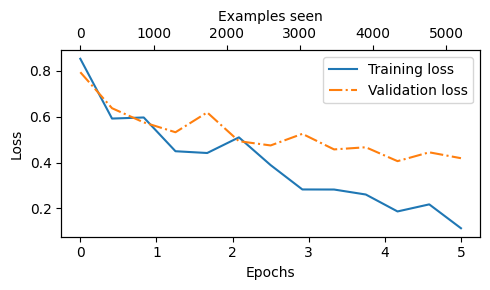

In [ ]:
import matplotlib.pyplot as plt
import torch

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation values
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")

    # Labels and legend
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Second x-axis for examples seen
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot to set scale
    ax2.set_xlabel("Examples seen")

    # Adjust layout and save the plot
    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

# Generate epoch and examples_seen tensors for plotting
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

# Plot the training and validation loss
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)


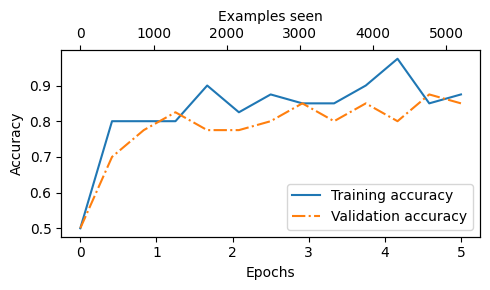

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(
 epochs_tensor, examples_seen_tensor, train_accs, val_accs,
 label="accuracy"
)

In [ ]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")


Training accuracy: 93.17%
Validation accuracy: 85.91%
Test accuracy: 84.67%


# Using the model to classify new texts

In [ ]:
import torch

def classify_review(
    text, model, tokenizer, device, max_length=None, pad_token_id=50256
):
    model.eval()

    # Tokenize input text
    input_ids = tokenizer.encode(text)

    # Get supported context length
    supported_context_length = model.pos_emb.weight.shape[1]

    # Trim or pad input to match max_length
    input_ids = input_ids[:min(max_length, supported_context_length)]
    input_ids += [pad_token_id] * (max_length - len(input_ids))

    # Convert to tensor and add batch dimension
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
        predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"


In [ ]:
text_1 = (
 "You are a winner you have been specially"
 " selected to receive $1000 cash or a $2000 award."
)
print(classify_review(
 text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [ ]:
text_2 = (
 "Hey, just wanted to check if we're still on"
 " for dinner tonight? Let me know!"
)
print(classify_review(
 text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [ ]:
text_2 = (
    "Congratulations! You have won a free vacation to the Bahamas! "
    "Click the link to claim your prize now!"
)
print(classify_review(text_2, model, tokenizer, device, max_length=train_dataset.max_length))


spam


In [ ]:
text_3 = (
    "Hey, are we still meeting for coffee tomorrow morning? Let me know what time works for you."
)
print(classify_review(text_3, model, tokenizer, device, max_length=train_dataset.max_length))

not spam


In [ ]:
text_4 = (
    "Important notice: Your bank account has been compromised. "
    "Please verify your identity immediately by logging into your account."
)
print(classify_review(text_4, model, tokenizer, device, max_length=train_dataset.max_length))


not spam


In [ ]:
torch.save(model.state_dict(), "review_classifier.pth")